**Remarque :**

Certaines termes utilisées dans ce notebook peuvent ne pas être exactes, à titre d'exemple :


*   Le terme *clé de regroupement* correspond à la colonne sur laquelle le regroupement est effectué, exemple : dans la requete SQL "SELECT COUNT(*) FROM T GROUPBY X" la clé de regroupement correspond à la colonne X
*   Le terme *propriétaire du bien* correspond au nom du professionnel/particulier qui vend/loue le bien, dont l'information est trouvée dans la colonne *DEALER_NAME*
*   Le terme *Facteur d'unicité* correspond à la valeur du ratio "nombre de valeurs uniques / nombre de lignes"



In [1]:
import pandas as pd
import numpy as np

# Aperçu des données

In [2]:
file_path = "./Dataset - Ads _ Levallois-Perret - 2019-08.xlsx"
df = pd.read_excel(file_path)
print("La table contient {} colonnes".format(len(df.columns)))
df.head()

La table contient 57 colonnes


,ID,URL,CRAWL_SOURCE,PROPERTY_TYPE,NEW_BUILD,DESCRIPTION,IMAGES,SURFACE,LAND_SURFACE,BALCONY_SURFACE,TERRACE_SURFACE,ROOM_COUNT,BEDROOM_COUNT,BATHROOM_COUNT,LUNCHROOM_COUNT,TOILET_COUNT,FURNISHED,FIREPLACE,AIR_CONDITIONING,GARDEN,SWIMMING_POOL,BALCONY,TERRACE,CELLAR,PARKING,PARKING_COUNT,HEATING_TYPES,HEATING_MODE,FLOOR,FLOOR_COUNT,CONSTRUCTION_YEAR,ELEVATOR,CARETAKER,ENERGY_CONSUMPTION,GREENHOUSE_GAS_CONSUMPTION,MARKETING_TYPE,PRICE,PRICE_M2,PRICE_EVENTS,RENTAL_EXPENSES,RENTAL_EXPENSES_INCLUDED,DEPOSIT,FEES,FEES_INCLUDED,EXCLUSIVE_MANDATE,AGENCIES_UNWANTED,OCCUPIED,DEALER_NAME,DEALER_TYPE,CITY_ID,CITY,ZIP_CODE,DEPT_CODE,PUBLICATION_START_DATE,PUBLICATION_END_DATE,LAST_CRAWL_DATE,LAST_PRICE_DECREASE_DATE
0,22c05930-0eb5-11e7-b53d-bbead8ba43fe,http://www.avendrealouer.fr/location/levallois...,A_VENDRE_A_LOUER,APARTMENT,0.0,"Au rez de chaussée d'un bel immeuble récent,ap...","[""https://cf-medias.avendrealouer.fr/image/_87...",72.00,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0,[],COLLECTIVE,NaN,NaN,NaN,1.0,NaN,NaN,NaN,RENT,1979.0,27.49,"[{""price"":1979,""date"":""2017-03-22""}]",276.00,1.0,NaN,NaN,NaN,False,NaN,NaN,Lamirand Et Associes,AGENCY,54178039,Levallois-Perret,92300.0,92,2017-03-22T04:07:56.095,NaN,2017-04-21T18:52:35.733,NaT
1,8d092fa0-bb99-11e8-a7c9-852783b5a69d,https://www.bienici.com/annonce/ag440414-16547...,BIEN_ICI,APARTMENT,0.0,Je vous propose un appartement dans la rue Col...,"[""http://photos.ubiflow.net/440414/165474561/p...",48.00,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,False,NaN,[],INDIVIDUAL,1.0,6.0,NaN,1.0,0.0,NaN,NaN,SALE,429000.0,8937.50,"[{""price"":452000.0,""date"":""2018-09-18""},{""pric...",NaN,NaN,NaN,NaN,0.0,False,NaN,0.0,Proprietes Privees,MANDATARY,54178039,Levallois-Perret,92300.0,92,2018-09-18T11:04:44.461,NaN,2019-06-06T10:08:10.89,2018-09-25
2,44b6a5c0-3466-11e9-8213-25cc7d9bf5fc,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,APARTMENT,0.0,"Dans un cadre arboré, calme et fleuri, un pent...","[""https://v.seloger.com/s/width/965/visuels/0/...",267.00,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,4970000.0,18614.23,"[{""price"":4970000.0,""date"":""2019-02-19""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,0.0,Propriétés Parisiennes,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-02-19T16:49:03.547,NaN,2019-06-13T08:22:14.314,NaT
3,e9e07ed0-812f-11e8-82aa-61eacebe4584,https://www.seloger.com/annonces/locations/bur...,SE_LOGER,PREMISES,0.0,"""Le meilleur coworking flexible de la ville, 5...","[""https://pix.yanport.com/ads/e9e07ed0-812f-11...",50.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,89.0,1.78,"[{""price"":89.0,""date"":""2018-07-06""}]",NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,Iwg,AGENCY,54178039,Levallois-Perret,92300.0,92,2018-07-06T15:18:59.805,NaN,2019-06-18T10:40:07.405,NaT
4,872302b0-5a21-11e9-950c-510fefc1ed35,https://www.bellesdemeures.com/annonces/vente/...,BELLES_DEMEURES,HOUSE,0.0,Levallois - Parc de la Planchette A toute prox...,"[""https://v.seloger.com/s/width/966/visuels/0/...",330.00,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SALE,2790000.0,8454.55,"[{""price"":3150000.0,""date"":""2019-04-08""},{""pri...",NaN,NaN,NaN,NaN,NaN,False,NaN,0.0,Daniel Feau Neuilly,AGENCY,54178039,Levallois-Perret,92300.0,92,2019-04-08T17:12:20.123,NaN,2019-06-14T15:02:18.155,2019-06-14


Il y a 3 colonnes qui contiennet des dates en format string, on va faire le parsing

In [3]:
df["PUBLICATION_START_DATE"] = pd.to_datetime(df.PUBLICATION_START_DATE)
df["PUBLICATION_END_DATE"] = pd.to_datetime(df.PUBLICATION_END_DATE)
df["LAST_CRAWL_DATE"] = pd.to_datetime(df.LAST_CRAWL_DATE)

Il y a beaucoup de cellules vides, on va regarder quelles colonnes contiennent le plus d'information

In [4]:
(df.isna().sum() / len(df)).sort_values(ascending=True).to_frame(name = "NaN ratio")

,NaN ratio
ID,0.000000
LAST_CRAWL_DATE,0.000000
MARKETING_TYPE,0.000000
PRICE_EVENTS,0.000000
EXCLUSIVE_MANDATE,0.000000
DEALER_TYPE,0.000000
CITY_ID,0.000000
CITY,0.000000
PARKING,0.000000
HEATING_TYPES,0.000000


On remarque qu'il y a 11 colonnes complètement vides, on va les supprimer

In [5]:
df.dropna(axis="columns", how="all", inplace=True)
#on regarde parmi les colonnes restantes, celles qui contiennent le plus de NaN
(df.isna().sum() / len(df)).sort_values(ascending=False)[:15].to_frame(name = "NaN ratio")

,NaN ratio
LAND_SURFACE,0.998614
SWIMMING_POOL,0.997227
GARDEN,0.993530
TERRACE_SURFACE,0.988447
DEPOSIT,0.974584
TERRACE,0.960259
FEES,0.956562
PARKING_COUNT,0.927449
AGENCIES_UNWANTED,0.907116
CARETAKER,0.885860


Les informations affichées sur l'interface de l'app Yanport peuvent être obtenues à partir des colonnes suivantes :


*   URL : le lien vers l'annonce
*   CRAWL_SOURCE : le site sur lequel l'annonce est publiée
*   DESCRIPTION : la description de l'annonce
*   IMAGES : les photos du bien
*   SURFACE : la surface du bien
*   MARKETING_TYPE : si le bien est en vente ou en location
*   PRICE : le prix du bien
*   PRICE_M2 : le prix du m²
*   DEALER_NAME : le nom du propriétaire
*   CITY : le nom de la commune
*   ZIP_CODE : le code postal
*   PUBLICATION_START_DATE : la date de publication de l'annonce



# Analyse
## Première approche : utilisation de GroupBy
On va se limiter dans un premier temps à analyser les données de **Imax Levallois-Perret**, et on généralisera par la suite sur toutes les données.

Pour regrouper les annonces d'un même bien, on peut faire un GroupBy sur les caractéristiques du bien, on suppose que les annonces portant sur le même bien indiquent les mêmes caractéristiques (prix, surface, ...).

La difficulté qui se pose est : Quelle colonnes devons-nous prendre comme clé de regroupement (GroupBy key) ?

On a 2 hypothèses :

1.   Les colonnes contenant des valeurs uniques sur toutes les lignes, ne sont pas utiles comme clé de regroupement, car un tel regroupement va donner que des singletons (1 annonce par bien)
2.   Les colonnes contenant la même valeur sur toutes les lignes, ne sont pas utiles non plus, car un tel regroupement va donner 1 seul groupe global (toutes les annonces portent sur le même bien).

On va alors commencer notre analyse en regardant le nombre de valeurs uniques de chaque colonne

In [6]:
#données de Imax Levallois-Perret
lmax_df = df[df.DEALER_NAME == "Imax Levallois-Perret"]
#nombre de valeurs uniques par colonne, pour les biens de ce propriétaire
lmax_df.nunique().to_frame(name = "unique count")

,unique count
ID,98
URL,98
CRAWL_SOURCE,5
PROPERTY_TYPE,2
NEW_BUILD,1
DESCRIPTION,98
IMAGES,98
SURFACE,22
LAND_SURFACE,0
TERRACE_SURFACE,0


On remarque que la colonne "PUBLICATION_START_DATE" contient quasiment que des valeurs distinctes, ceci est logique car même sur 2 annonces d'un même bien il est impossible que le propriétaire puisse les publier au même moment (il doit y avoir un délai de quelques minutes voir heures).

Si on admet comme hypothèse que les annonces d'un bien sont publiées dans des dates proches, ça serait peut être pratique d'ignorer la valeur des heures, minutes, secondes et millisecondes, et ne considérer que le jour, le mois et l'année.

Une façon plus propre de détecter les dates proches est d'utiliser un clustering sur la valeur du timestamp de la date de publication, car l'approche précédente va séparer les annonces proches dont les valeurs de jour sont différents (comme par exemple, une annonce publiée à 23:59 et une autre à 00:00 du jour suivant seront considérée différentes, selon la première approche, même si la différence de temps n'est que 1 minute)

In [7]:
#pour simplifier, on applique la première approche (ignorer les heures, minutes et secondes)
df["NORMALIZED_PUBLICATION_START_DATE"] = df["PUBLICATION_START_DATE"].dt.normalize()

#actualiser lmax_df
lmax_df = df[df.DEALER_NAME == "Imax Levallois-Perret"]

print("Dates de publication distinctes : {}".format(df["PUBLICATION_START_DATE"].nunique()))
print("Dates de publication normalisées distinctes : {}".\
      format(df["NORMALIZED_PUBLICATION_START_DATE"].nunique()))

Dates de publication distinctes : 2103
Dates de publication normalisées distinctes : 372


Pour donner un facteur plus significatif sur le nombre de valeurs uniques par colonne, on va diviser le nombre de valeurs uniques de chaque colonne par le nombre des lignes total, on va appeller ce facteur **Facteur d'unicité de la colonne**

L'interprétation de la valeur de ce facteur est très simple :

*   Plus la valeur est proche de 1, plus il y a de valeurs uniques sur la colonne
*   Plus la valeur est proche de 0, moins il y a de valeurs uniques sur la colonne


Une clé de regroupement évidente est le nom du propriétaire (il n'est pas possible que 2 annonces portant sur le même bien soient publiées par 2 propriétaires différents). On va calculer le facteur d'unicité de chaque colonne, en séparant les données de chaque propriétaire. On calcule ensuite pour chaque colonne, le facteur d'unicité moyen.

In [8]:
print("Il y a {} propriétaires distincts".format(df.DEALER_NAME.nunique()))

Il y a 553 propriétaires distincts


In [9]:
def unicity_df(df=df):
  result_df = None
  #pour éviter d'avoir 553 colonnes,
  #on va se limiter aux 10 premiers propriétaires dans un premier temps
  for dealer in df.DEALER_NAME.unique()[:10]:
    #données de ce propriétaire
    dealer_df = df[df.DEALER_NAME == dealer]
    #aucun intéret s'il n'a qu'1 seule annonce
    if(len(dealer_df) <= 1):
      continue
    #facteur d'unicité = nombre de valeur uniques (y compris le NaN) / nombre de lignes
    unique_fact = (dealer_df.nunique(dropna=False) / len(dealer_df)).to_frame(name = dealer)
    #le premier résultat on l'affecte directement à result_df
    if result_df is None:
      result_df = unique_fact
    #le reste on fait un merge
    else:
      result_df[dealer] = unique_fact

  #ajout de quelques aggrégats sur la facteur d'unicité (sur tous les propriétaires pris)
  result_df["Min"] = result_df.min(axis=1)
  result_df["Max"] = result_df.max(axis=1)
  result_df["Mean"] = result_df.mean(axis=1)
  result_df["Std"] = result_df.std(axis=1)

  #on s'intéresse surtout à la moyenne de ce facteur
  return result_df.sort_values(by="Mean", ascending=False)

unicity_df()

,Proprietes Privees,Propriétés Parisiennes,Iwg,Daniel Feau Neuilly,Building Partners,Cabinet De L''ouest Parisien,Yespark,Impact Immo,Min,Max,Mean,Std
ID,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000000
URL,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000000
LAST_CRAWL_DATE,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000000
PUBLICATION_START_DATE,0.636364,1.0,1.000000,1.0,0.909722,1.0,1.000000,1.000000,0.636364,1.0,0.918245,0.143448
IMAGES,0.818182,1.0,1.000000,1.0,0.694444,1.0,1.000000,0.928571,0.694444,1.0,0.913564,0.122547
DESCRIPTION,0.757576,0.5,1.000000,1.0,0.965278,1.0,1.000000,1.000000,0.500000,1.0,0.872285,0.199215
PRICE_EVENTS,0.515152,0.5,1.000000,1.0,0.812500,1.0,1.000000,0.928571,0.500000,1.0,0.825622,0.217085
NORMALIZED_PUBLICATION_START_DATE,0.181818,0.5,0.714286,1.0,0.493056,1.0,0.714286,0.714286,0.181818,1.0,0.649955,0.294180
PRICE_M2,0.272727,0.5,1.000000,0.5,0.347222,1.0,1.000000,0.571429,0.272727,1.0,0.646411,0.302884
PRICE,0.272727,0.5,1.000000,0.5,0.319444,1.0,0.928571,0.500000,0.272727,1.0,0.629347,0.300379


On remarque que :


*   Les 3 premières colonnes (ID, URL, LAST_CRAWL_DATE) ont toujours des valeurs uniques, on va donc les exclure des clés de regroupement
*   Les 4 colonnes qui suivent (PUBLICATION_START_DATE, IMAGES, DESCRIPTION, PRICE_EVENTS) ont très peu de valeurs communes entre les lignes (facteur > 80% donc le nombre de valeurs distinctes est proches du nombre de lignes), l'inclusion de ces colonnes dans les clés de regroupement va créer un grand nombre de groupes, on préfère donc les exclure

La colonne "CRAWL_SOURCE" devrait évidemment être exclue, car le but est de regrouper ensemble des annonces publiées sur des sites différents.

La colonne "PRICE_M2" peut aussi être exclue car elle n'ajoute aucune valeur vu qu'elle correspond au rapport "PRICE / SURFACE".

In [10]:
#les colonnes à exclure de la liste des clés de regroupement
#on exclut aussi le site de publication d'annonce CRAWL_SOURCE
#et le price du m² car l'information est corrélée avec 
#(PRICE / SURFACE)
ignored_columns = ["ID", "URL", "LAST_CRAWL_DATE",
                  "PUBLICATION_START_DATE", "IMAGES",
                  "DESCRIPTION", "PRICE_EVENTS"] +\
                  ["CRAWL_SOURCE"] +\
                  ["PRICE_M2"]# + ["NORMALIZED_PUBLICATION_START_DATE"]
#les colonnes à utiliser comme clés de regroupement
key_columns = [col for col in df.columns if col not in ignored_columns]

Un 2ème problème qui se pose, c'est que les clés de regroupement qui contiennent des valeurs nulles, ne permettent pas de faire un regroupement correct. Et il y a beaucoup de colonnes dont la majorité de valeurs sont nulles.

In [11]:
nan_df = df.isna().sum().to_frame(name = "NaN count")
print("Il y a {0} colonnes parmi {1} qui contiennent des valeurs nulles".\
      format(len(nan_df[nan_df["NaN count"] > 0]), len(nan_df)))

Il y a 30 colonnes parmi 47 qui contiennent des valeurs nulles


Il y a 30 colonnes qu'on ne peut pas utiliser directement comme clé de regroupement car elles contiennent des valeurs nulles. On ne veut pas les abandonner car elles contiennent des informations pouvant augmenter la précision de regroupement.

Une solution qu'on peut utiliser dans ce cas est le remplissage des cellules vides par des valeurs adéquates (valeur moyenne pour les colonnes numériques/date et valeur la plus fréquente pour les colonnes catégorielles), mais une telle solution pourra éventuellement biaiser les données.

Une solution plus propre sur laquelle on peut s'appuyer est comme suit :

*   Séparer d'abord les données par le nom de propriétaire (DEALER_NAME) en plusieurs dataframes
*   Pour chaque sous-dataframe résultant, regrouper les annonces selon les clés suivantes :
  *   Les colonnes ne contenant pas de valeurs nulles (parmi les 17 colonnes trouvées précédemment)
  *   Les colonnes ne contenant pas de valeurs nulles sur ce sous-dataframe

Le but de séparer les données par nom propriétaire est de pouvoir utiliser comme clé de regroupement, les informations renseignées par un propriétaire P1, mais qui peuvent être vides chez les autres propriétaires P2, P3, ... Et ceux pour améliorer au maximum la précision de regroupement.

**Exemple** : Nous avons 2 colonnes col1 et col2. La colonne col1 ne contient pas de valeurs nulles, col2 contient quelques cellules nulles et on ne peut donc pas l'utiliser comme clé de regroupement. Nous avons 2 propriétaires dealer1 et dealer2, la colonne col2 contient des valeurs nulles pour dealer1, mais dealer2 a bien renseigné toutes les valeurs de cette colonne, on va donc regrouper les annonces de dealer1 avec [col1] et celles de dealer2 avec [col1, col2]

In [12]:
#on essaie avec les donnée de 'lmax'
#les colonnes de 'lmax' qui contiennet des nan
lmax_nan_columns = lmax_df.columns[lmax_df.isna().any()]

print("Il y a {0} colonnes parmi {1} qui contiennent des valeurs nulles pour le dealer 'lmax'".\
      format(len(lmax_nan_columns), len(lmax_df.columns)))

Il y a 26 colonnes parmi 47 qui contiennent des valeurs nulles pour le dealer 'lmax'


On remarque que 4 colonnes qui contiennent des valeurs nulles, sont bien renseignées par ce propriétaire

Maintenant on fait le GroupBy

In [13]:
def group_by_dealer(in_df):
  #les colonnes de ce propriétaire qui contiennet des nan
  nan_columns = in_df.columns[in_df.isna().any()]
  #les colonnes clés de regroupement pour ce propriétaire
  #on exclut les colonnes qui contiennent des nan pour ce dealer uniquement
  keep_columns = [col for col in key_columns if col not in nan_columns]

  result = in_df.groupby(keep_columns[:]).agg(
      #le nombre d'annonces total pour ce bien
      count=pd.NamedAgg(column="ID", aggfunc="count"),
      #les sites sources
      sources=pd.NamedAgg(column="CRAWL_SOURCE", aggfunc=lambda x : list(x)),
      #les lien vers les annonces
      urls=pd.NamedAgg(column="URL", aggfunc=lambda x : list(x)),
      #on prend une parmi des descriptions des annonces
      first_description=pd.NamedAgg(column="DESCRIPTION", aggfunc=(lambda x : list(x)[0])),
      #le prix
      price=pd.NamedAgg(column="PRICE", aggfunc=lambda x : list(x)[0]),
      #le prix par m2
      price_m2=pd.NamedAgg(column="PRICE_M2", aggfunc=lambda x : list(x)[0]),
      #les identifiants uniques de chacunes des annonces
      ids=pd.NamedAgg(column="ID", aggfunc=lambda x : list(x)),
      #la commune
      city=pd.NamedAgg(column="CITY", aggfunc=lambda x : list(x)[0]),
      #le code postal
      postal_code=pd.NamedAgg(column="ZIP_CODE", aggfunc=lambda x : list(x)[0]),
      #le nom du propriétaire
      dealer=pd.NamedAgg(column="DEALER_NAME", aggfunc=lambda x : list(x)[0]),
  ).sort_values(by="count", ascending=False).reset_index(drop=True)

  return result

group_by_dealer(lmax_df).head(5)

,count,sources,urls,first_description,price,price_m2,ids,city,postal_code,dealer
0,3,"[SE_LOGER, LE_BON_COIN, BIEN_ICI]",[https://www.seloger.com/annonces/achat-de-pre...,LEVALLOIS - 4 PIÈCES - 1 099 000 EUROS FAI Par...,1099000.0,11329.90,"[03699de0-a8ae-11e9-aa5e-8b8909b4f047, 8103902...",Levallois-Perret,92300.0,Imax Levallois-Perret
1,3,"[A_VENDRE_A_LOUER, SE_LOGER, LE_BON_COIN]",[https://www.avendrealouer.fr/vente/levallois-...,LEVALLOIS - 4 PIECES - 599 000 EUROS (FAI) Sit...,599000.0,8557.14,"[98936d50-9e7d-11e9-a8e6-0de7b497e456, 5b1b438...",Levallois-Perret,92300.0,Imax Levallois-Perret
2,3,"[BIEN_ICI, LE_BON_COIN, SE_LOGER]",[https://www.bienici.com/annonce/pericles-2629...,"LEVALLOIS - STUDIO - EN VIDE Rue Marjolin, à p...",966.0,35.78,"[ea665310-c2e3-11e9-81e9-5f24299f2ef3, bba9d75...",Levallois-Perret,92300.0,Imax Levallois-Perret
3,2,"[LE_BON_COIN, LOGIC_IMMO]",[https://www.leboncoin.fr/ventes_immobilieres/...,LEVALLOIS - 2 PIECES - 449 000 EUROS FAI\nSitu...,449000.0,9163.27,"[b7b50840-8732-11e9-a7f2-f5443208fc78, a7161e7...",Levallois-Perret,92300.0,Imax Levallois-Perret
4,2,"[SE_LOGER, BIEN_ICI]",[https://www.seloger.com/annonces/achat/appart...,LEVALLOIS - 2 PIÈCES - 559 000 EUROS FAI Situé...,559000.0,9982.14,"[1c42f4e0-a4a5-11e9-aa5e-8b8909b4f047, 5c79773...",Levallois-Perret,92300.0,Imax Levallois-Perret


Maintenant, il reste à ajouter les informations relatifs au propriétaire :


*   Nombre total de biens en location
*   Nombre total de biens en vente

Pour ce faire, on crée un nouveau dataframe qui contient les informations ci-dessus et on fait une jointure avec la table précédente

In [14]:
dealer_info_df = df.groupby("DEALER_NAME").agg(
    en_vente=pd.NamedAgg(column="MARKETING_TYPE", aggfunc=lambda x : len([y for y in x if y == "SALE"])),
    en_location=pd.NamedAgg(column="MARKETING_TYPE", aggfunc=lambda x : len([y for y in x if y == "RENT"])),
)
dealer_info_df.sort_values(by="en_vente", ascending=False).head(5)

,en_vente,en_location
DEALER_NAME,,
Building Partners,144,0
Imax Levallois-Perret,76,22
BNP Paribas Immobilier,50,0
BUILDING PARTNERS LEVALLOIS PERRET,43,0
Engel & Völkers Paris,39,0


In [15]:
group_by_dealer(lmax_df).join(dealer_info_df, on='dealer').head(5)

,count,sources,urls,first_description,price,price_m2,ids,city,postal_code,dealer,en_vente,en_location
0,3,"[SE_LOGER, LE_BON_COIN, BIEN_ICI]",[https://www.seloger.com/annonces/achat-de-pre...,LEVALLOIS - 4 PIÈCES - 1 099 000 EUROS FAI Par...,1099000.0,11329.90,"[03699de0-a8ae-11e9-aa5e-8b8909b4f047, 8103902...",Levallois-Perret,92300.0,Imax Levallois-Perret,76,22
1,3,"[A_VENDRE_A_LOUER, SE_LOGER, LE_BON_COIN]",[https://www.avendrealouer.fr/vente/levallois-...,LEVALLOIS - 4 PIECES - 599 000 EUROS (FAI) Sit...,599000.0,8557.14,"[98936d50-9e7d-11e9-a8e6-0de7b497e456, 5b1b438...",Levallois-Perret,92300.0,Imax Levallois-Perret,76,22
2,3,"[BIEN_ICI, LE_BON_COIN, SE_LOGER]",[https://www.bienici.com/annonce/pericles-2629...,"LEVALLOIS - STUDIO - EN VIDE Rue Marjolin, à p...",966.0,35.78,"[ea665310-c2e3-11e9-81e9-5f24299f2ef3, bba9d75...",Levallois-Perret,92300.0,Imax Levallois-Perret,76,22
3,2,"[LE_BON_COIN, LOGIC_IMMO]",[https://www.leboncoin.fr/ventes_immobilieres/...,LEVALLOIS - 2 PIECES - 449 000 EUROS FAI\nSitu...,449000.0,9163.27,"[b7b50840-8732-11e9-a7f2-f5443208fc78, a7161e7...",Levallois-Perret,92300.0,Imax Levallois-Perret,76,22
4,2,"[SE_LOGER, BIEN_ICI]",[https://www.seloger.com/annonces/achat/appart...,LEVALLOIS - 2 PIÈCES - 559 000 EUROS FAI Situé...,559000.0,9982.14,"[1c42f4e0-a4a5-11e9-aa5e-8b8909b4f047, 5c79773...",Levallois-Perret,92300.0,Imax Levallois-Perret,76,22


Dans le dataframe résultant, nous avons les colonnes suivantes :


*   count : nombre d'annonces portant sur le bien
*   sources : la liste des sites dans lesquels les annonces sont publiées
*   urls : la liste des liens vers les pages des annonces
*   first_description : la description de la première annonce
*   price : le prix du bien
*   price_m2 : le prix au m² du bien
*   ids : la liste des identifiants uniques des annonces
*   city, postal_code, dealer : c'est clair
*   en_vente, en_location : nombre de biens en vente/location total publiés par le même propriétaire


Maintenant, on refait la même chose sur tous les noms des propriétaires

In [16]:
all_df = pd.concat([group_by_dealer(df[df.DEALER_NAME == dealer]) for dealer in df.DEALER_NAME.unique()])\
.join(dealer_info_df, on='dealer')

In [21]:
all_df.sort_values(by="count", ascending=False)

,count,sources,urls,first_description,price,price_m2,ids,city,postal_code,dealer,en_vente,en_location
0,10,"[SE_LOGER, SE_LOGER, SE_LOGER, SE_LOGER, SE_LO...",[https://www.seloger.com/annonces/locations/bu...,Situés au sein d'un immeuble moderne à proximi...,4375.0,25.00,"[67436240-b9d6-11e9-9fab-c3006e339e11, 67cf75a...",Levallois-Perret,92300.0,Groupe Babylone,4,22
0,4,"[LOGIC_IMMO, EXPLORIMMO, LUX_RESIDENCE, PROPRI...",[https://www.logic-immo.com/detail-vente-12c01...,"52m² au 4eme et dernier sans ascenseur, tout l...",504000.0,9692.31,"[3919a320-91f4-11e9-bc97-e75542746f87, 416fb25...",Levallois-Perret,92300.0,Bourse De L'immobilier,10,0
0,4,"[LE_BON_COIN, LOGIC_IMMO, EXPLORIMMO, BIEN_ICI]",[https://www.leboncoin.fr/ventes_immobilieres/...,Bel appartement dans un immeuble récent\n\nLEV...,465000.0,9300.00,"[22d17960-81e8-11e9-a5bb-298a91e57a68, 3bc3a74...",Levallois-Perret,92300.0,Haussmann Prestige,6,0
0,3,"[SE_LOGER, BIEN_ICI, EXPLORIMMO]",[https://www.seloger.com/annonces/achat/appart...,ORPI vous propose ce joli petit 2 pièces de 21...,198000.0,9428.57,"[c8e1e7d0-c357-11e9-81e9-5f24299f2ef3, 7c0de3c...",Levallois-Perret,92300.0,Mcd,3,0
3,3,"[LOGIC_IMMO, MEILLEURS_AGENTS, SE_LOGER]",[https://www.logic-immo.com/detail-vente-01c59...,Levallois/quartier Mairie. EngelVolkers vous p...,749000.0,12080.65,"[af7d2260-8dc8-11e9-a7f2-f5443208fc78, f1650f9...",Levallois-Perret,92300.0,Engel & Völkers Paris,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
8,1,[LOGIC_IMMO],[https://www.logic-immo.com/detail-vente-ede03...,"Levallois- Perret, quartier de l'hôtel de Vill...",358000.0,13259.26,[a3173fa0-9a03-11e9-b883-7d9a2d13f1b7],Levallois-Perret,92300.0,Engel & Völkers Paris,39,0
14,1,[LOGIC_IMMO],[https://www.logic-immo.com/detail-vente-5b2a9...,SUPERBE SURFACE AU COEUR DE LEVALLOIS PERRET. ...,95000.0,1187.50,[df0319a0-0212-11e9-9d9b-7591d677cbca],Levallois-Perret,92300.0,Sadone Immobilier,9,10
13,1,[BIEN_ICI],[https://www.bienici.com/annonce/immo-facile-1...,Vous souhaitez vous installer au centre de Lev...,190000.0,3454.55,[4d1e5a80-ec6f-11e8-b183-9353fd1de752],Levallois-Perret,92300.0,Sadone Immobilier,9,10
12,1,[EXPLORIMMO],[https://immobilier.lefigaro.fr/annonces/annon...,Vous souhaitez vous installer au centre de Lev...,190000.0,3454.55,[1f9da170-214e-11e8-83df-8b1ecbb18b0f],Levallois-Perret,92300.0,Sadone Immobilier,9,10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd56d8e2dd0>]],
      dtype=object)

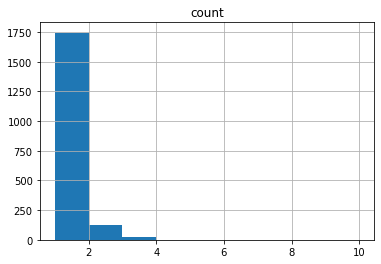

In [18]:
all_df.hist(column="count", bins=9)

In [19]:
print("Annonces avant le regroupement : {}".format(len(df)))
print("Annonces après le regroupement : {}".format(len(all_df)))

Annonces avant le regroupement : 2164
Annonces après le regroupement : 1894


Avec ce regroupement, on a réduit le nombre d'annonce de **2164** à **1895**.

Si on exclut la colonne "NORMALIZED_PUBLICATION_START_DATE" des clés de regroupement, on peut réduire le nombre d'annonces jusqu'à **~1600**, mais on risque de regrouper des annonces publiées sur des périodes de temps différentes.

## Deuxième approche : utilisation du clustering
On peut améliorer le résultat en utilisant le clustering basé sur la densité (comme l'algorithme de DBSCAN) sur les colonnes de type date (convertis en timestamp) et de type float. Les labels issues du clustering peuvent être utilisés comme clés de regroupement au lieu d'utiliser les valeurs date/float brutes.

On n'a pas besoin d'appliquer le clustering sur les autres types de colonnes (enum, int ...) car le GroupBy basé des colonnes discrètes ou catégorielle est bon.

**PS** : préférer l'utilisation de DBSCAN car il permet de choisir le rayon des clusters, qui corresponds à la différence maximale permise pour regrouper 2 dates ou float.

# Pistes d'amélioration
Si on veut aller encore plus loin, on peut :

*   Comparer les images des annonces et voir si des annonces ont des images similaires/identiques
*   Extraire d'autres caractéristiques comme l'adresse exact (numéro et nom de rue) du bien avec du web scrapping (utiliser BeautifulSoup par ex)

Une bonne compréhension du contexte est aussi importante car elle permet de mieux filtrer les colonnes utilisées pour le regroupement.

</br>
</br>

<b>Oussama BOUZAOUIT</b>